In [14]:
import ray
import time
from ray import serve

iterations_per_second = 100000000 # 100M
@ray.remote
class PrefixTreeSimulator:
    def __init__(self, start_time):
        self.start_time = start_time

    async def insert(self, text, tenant):
        for _ in range(iterations_per_second):
            pass
        print(f"inserted {text} after {time.time() - self.start_time} seconds")

    async def prefix_match(self, text):
        for _ in range(iterations_per_second):
            pass
        print(f"Found tenant 'dummy' for prefix {text} after {time.time() - self.start_time} seconds")

tree_actor = PrefixTreeSimulator.remote(time.time())
obj_refs = []
for i in range(5):
    obj_refs.append(tree_actor.prefix_match.remote(f"foo{i}"))
results = ray.get(obj_refs)

1746750918.256327


Benchmarking tree of size ~1,000 inserts...
Inserting 1000 random strings to warm-up...
Benchmarking 10 insert calls...
Benchmarking 10 prefix_match calls...
Benchmarking 10 evict_tenant_by_lru calls...
  insert: 0.010 ms | match: 0.010 ms | evict: 0.006 ms
Benchmarking tree of size ~10,000 inserts...
Inserting 10000 random strings to warm-up...
Benchmarking 10 insert calls...
Benchmarking 10 prefix_match calls...
Benchmarking 10 evict_tenant_by_lru calls...
  insert: 0.011 ms | match: 0.008 ms | evict: 0.005 ms
Benchmarking tree of size ~100,000 inserts...
Inserting 100000 random strings to warm-up...
Benchmarking 10 insert calls...
Benchmarking 10 prefix_match calls...
Benchmarking 10 evict_tenant_by_lru calls...
  insert: 0.017 ms | match: 0.010 ms | evict: 0.006 ms
Benchmarking tree of size ~1,000,000 inserts...
Inserting 1000000 random strings to warm-up...
Benchmarking 10 insert calls...
Benchmarking 10 prefix_match calls...
Benchmarking 10 evict_tenant_by_lru calls...
  insert: 

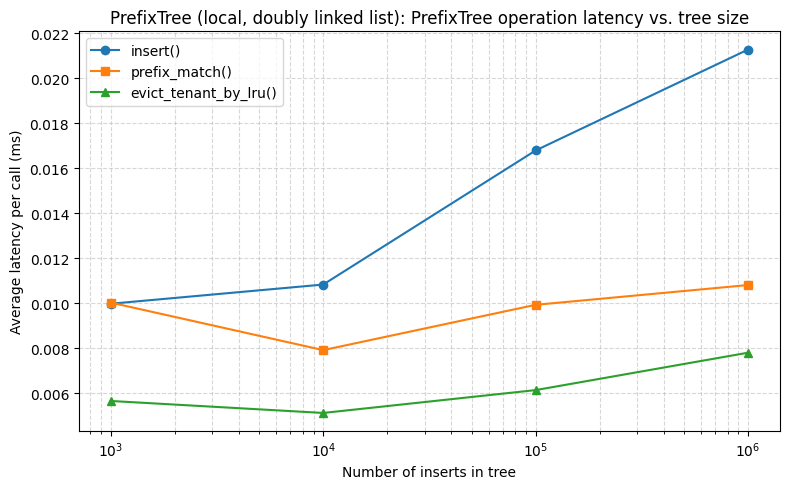

Total time taken: 28.24716281890869 seconds


(autoscaler +20m1s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.


In [ ]:
import ray
import time
import random
import string
import matplotlib.pyplot as plt
import logging
from prefix_tree import PrefixTree, PrefixTreeActor, PrefixTreeDeployment


# Disable all warnings and below across the entire application:
logging.disable(logging.WARNING)


# 1. Configuration
TREE_SIZES = [10**3, 10**4, 10**5, 10**6]
NUM_SAMPLES = 10
STR_LEN = 10
TENANT = "tenant_1"
EVICT_SIZE = 10

def random_digit_string(length: int) -> str:
    return "".join(random.choice(string.digits) for _ in range(length))

async def benchmark_for_size(n_inserts: int, type_of_tree: str):
    # tree = PrefixTreeActor.remote() if remote else PrefixTree()
    if type_of_tree == "actor":
        tree = PrefixTreeActor.remote()
    elif type_of_tree == "deployment":
        tree = serve.run(PrefixTreeDeployment.bind())
    elif type_of_tree == "local":
        tree = PrefixTree()
    # Warm-up: n_inserts random strings
    print(f"Inserting {n_inserts} random strings to warm-up...")
    texts = [random_digit_string(STR_LEN) for _ in range(n_inserts)]
    tenants = [TENANT] * n_inserts
    time_secs = list(range(n_inserts))
    if type_of_tree == "actor" or type_of_tree == "deployment":
        await tree.insert_many.remote(texts, tenants, time_secs)
    else:
        tree.insert_many(texts, tenants, time_secs)

    # Prepare sample inputs
    samples = [random_digit_string(STR_LEN) for _ in range(NUM_SAMPLES)]

    # Benchmark insert
    print(f"Benchmarking {NUM_SAMPLES} insert calls...")
    t0 = time.perf_counter()
    for i, s in enumerate(samples):
        if type_of_tree == "actor" or type_of_tree == "deployment":
            await tree.insert.remote(s, TENANT, time_sec=n_inserts + i)
        else:
            tree.insert(s, TENANT, time_sec=n_inserts + i)
    t_insert = (time.perf_counter() - t0) / NUM_SAMPLES * 1e3  # ms
    # Benchmark prefix_match
    print(f"Benchmarking {NUM_SAMPLES} prefix_match calls...")
    t0 = time.perf_counter()
    for s in samples:
        if type_of_tree == "actor" or type_of_tree == "deployment":
            _ = await tree.prefix_match.remote(s)
        else:
            _ = tree.prefix_match(s)
    t_match = (time.perf_counter() - t0) / NUM_SAMPLES * 1e3

    # Benchmark evict_tenant_by_lru
    print(f"Benchmarking {NUM_SAMPLES} evict_tenant_by_lru calls...")
    t0 = time.perf_counter()
    for _ in range(NUM_SAMPLES):
        if type_of_tree == "actor" or type_of_tree == "deployment":
            _ = await tree.evict_tenant_by_lru.remote(TENANT, EVICT_SIZE)
        else:
            _ = tree.evict_tenant_by_lru(TENANT, EVICT_SIZE)
    t_evict = (time.perf_counter() - t0) / NUM_SAMPLES * 1e3
    return t_insert, t_match, t_evict

async def main():
    insert_times = []
    match_times = []
    evict_times = []
    type_of_tree = "local"
    for size in TREE_SIZES:
        print(f"Benchmarking tree of size ~{size:,} inserts...")
        t_ins, t_mat, t_evic = await benchmark_for_size(size, type_of_tree)
        print(f"  insert: {t_ins:.3f} ms | match: {t_mat:.3f} ms | evict: {t_evic:.3f} ms")
        insert_times.append(t_ins)
        match_times.append(t_mat)
        evict_times.append(t_evic)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(TREE_SIZES, insert_times, marker="o", label="insert()")
    plt.plot(TREE_SIZES, match_times,  marker="s", label="prefix_match()")
    plt.plot(TREE_SIZES, evict_times,   marker="^", label="evict_tenant_by_lru()")
    plt.xscale("log")
    plt.xlabel("Number of inserts in tree")
    plt.ylabel("Average latency per call (ms)")
    plt.title(f"PrefixTree ({type_of_tree}, doubly linked list): PrefixTree operation latency vs. tree size")
    plt.legend()
    plt.grid(which="both", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    start_time = time.time()
    await main()
    end_time = time.time()
    print(f"Total time taken: {end_time - start_time} seconds")
